In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from varname import nameof

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Create dataset for regression analysis

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df.tail(20)

,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,scaled_district_heat,aggregated(incl_small_chp),the_combined_slp,the_combined_rlm,bdew [TWh],gas_to_electricity,...,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2022-04-14,0.462796,0.142559,0.021820,0.036367,0.032524,0.696066,0.705328,1.371902,NaN,0.463700,...,2022,4,Thursday,3,0,0,0,0,0,0
2022-04-15,0.568901,0.193393,0.029601,0.049335,0.041036,0.882265,0.783211,1.210300,NaN,0.303909,...,2022,4,Friday,4,0,1,0,0,1,0
2022-04-16,0.720138,0.253792,0.038846,0.064743,0.052469,1.129987,0.944962,1.176030,NaN,0.261135,...,2022,4,Saturday,5,0,0,1,0,0,0
2022-04-17,0.794404,0.288742,0.044195,0.073659,0.058390,1.259390,1.056941,1.112268,NaN,0.237541,...,2022,4,Sunday,6,0,0,1,0,0,0
2022-04-18,0.774970,0.307089,0.047003,0.078339,0.058441,1.265842,1.040536,1.182538,NaN,0.252219,...,2022,4,Monday,0,1,0,0,0,1,0
2022-04-19,0.754772,0.296070,0.045317,0.075528,0.056742,1.228430,1.043999,1.440223,NaN,0.416655,...,2022,4,Tuesday,1,0,0,0,0,0,0
2022-04-20,0.763137,0.297814,0.045584,0.075973,0.057281,1.239789,1.020422,1.480735,NaN,0.364125,...,2022,4,Wednesday,2,0,0,0,0,0,0
2022-04-21,0.740021,0.287206,0.043960,0.073267,0.055454,1.199909,0.976224,1.452386,NaN,0.348466,...,2022,4,Thursday,3,0,0,0,0,0,0
2022-04-22,0.683722,0.252083,0.038584,0.064307,0.050463,1.089159,0.897008,1.309642,NaN,0.283140,...,2022,4,Friday,4,0,1,0,0,0,0
2022-04-23,0.633866,0.210445,0.032211,0.053685,0.045430,0.975636,0.796759,1.042793,NaN,0.202615,...,2022,4,Saturday,5,0,0,1,0,0,0


In [5]:
df = df[df.index.duplicated()==False]  

In [6]:
solar = pd.read_csv(os.path.join(data_path, "solar.csv"), index_col=0)
solar.index = pd.DatetimeIndex(solar.index)
solar = solar.resample("D").mean()
solar.loc[(solar.index >= df.index[0]) & (solar.index <= df.index[-1])]
solar[solar.index.duplicated()==False]

solar = solar * 2.77778e-7
solar = solar.rename(columns={"solar [J/m^2]" : "solar [kWh/m^2]"})

In [7]:
temperature = pd.read_csv(os.path.join(data_path, "aggregated_temperature.csv"), index_col=0)
temperature.index = pd.DatetimeIndex(temperature.index)
temperature = temperature.resample("D").mean()
temperature = temperature.loc[df.index[0]:df.index[-1]]
temperature[temperature.index.duplicated()==False]

ref_temperature = pd.read_csv(os.path.join(data_path, "aggregated_reference_temperature.csv"), index_col=0)
ref_temperature.index = pd.DatetimeIndex(ref_temperature.index)
ref_temperature = ref_temperature.resample("D").mean()
ref_temperature = ref_temperature.loc[df.index[0]:df.index[-1]]

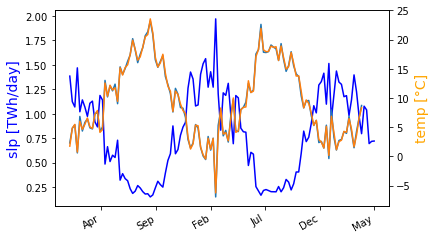

In [8]:
fig,ax = plt.subplots()

ax.plot(df["scaled_space_private"].resample("w").mean(), color="blue")
ax.set_ylabel("slp [TWh/day]",  color="blue", fontsize=14)

ax2=ax.twinx()
ax2.plot(pd.concat([temperature, ref_temperature], axis=1).resample("w").mean())
ax2.set_ylabel("temp [°C]", color="orange", fontsize=14)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.show()

temperature.index = df.index
ref_temperature.index = df.index

df["temperature"] = temperature
df["ref_temperature"] = ref_temperature

# Disaggregation based on fundamental assumption / energy balances

plt.figure(figsize=(10,5))

entso_g = df['bdew [TWh]']
entso_g.plot(label='ENTSO-G')

slp_res = entso_g - df['aggregated(incl_small_chp)']
plt.plot(df.index, slp_res, color='tab:red', label=' minus SLP', linewidth=0.5)
plt.fill_between(df.index, entso_g, slp_res, color='tab:red', alpha=0.1)

power_res = slp_res - df['gas_to_electricity']
plt.plot(df.index, power_res, color='tab:grey', label=' minus power sector', linewidth=0.5)
plt.fill_between(df.index, slp_res, power_res, color='tab:grey', alpha=0.1)

#plt.fill_between(df.index, power_res, 0, color='tab:blue', alpha=0.1)


plt.xlim('2021-01-01', '2022-03-25')
plt.ylim(0, 6.5)
plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right')
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))


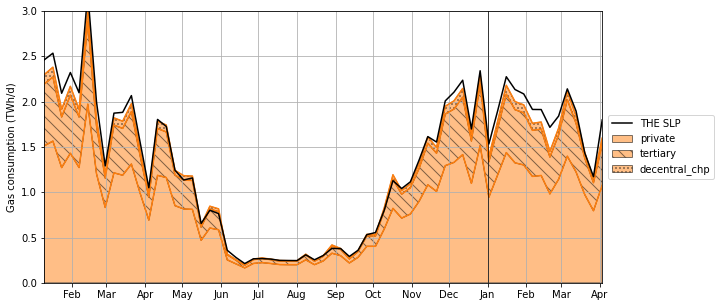

In [9]:
#weekly
plt.figure(figsize=(10,5))
dft = df.resample("1w").mean().dropna()
plt.xlim(dft.index[[0, -1]])

#scaling factors from AGEBL
private = dft["scaled_space_private"] 
tertiary = dft["scaled_space_tertiary"]
decentral_chp = dft["scaled_decentral_chp"]

bottom = 0
for sector,h,label in [(private, " ", "private"), (tertiary,  "\\\\", "tertiary"), (decentral_chp, "...", "decentral_chp")]:
    plt.fill_between(dft.index, bottom, sector+bottom, color="tab:orange", hatch=h, edgecolor="k", alpha=0.5, label=label)
    bottom += sector 
    plt.plot(dft.index, bottom, color="tab:orange")


plt.plot(dft.index, dft['the_combined_slp'], label='THE SLP', color="k")

plt.ylim(0, 3)
plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

plt.figure(figsize=(10,5))
dft = df.dropna()
plt.xlim(dft.index[[0, -1]])

#scaling factors from AGEBL
private = dft["residential"]#dft['aggregated(no_dist_heat)'] * 253 / 362
industry = dft["commercial"]*25 / 110#dft['aggregated(no_dist_heat)'] * 25 / 362
tertiary = dft["commercial"]*85 / 110#dft['aggregated(no_dist_heat)'] * 85 / 362

bottom = 0
for sector,h,label in [(private, " ", "private"), (tertiary,  "\\\\", "tertiary"), (industry, "...", "industry")]:
    plt.fill_between(dft.index, bottom, sector+bottom, color="tab:orange", hatch=h, edgecolor="k", alpha=0.5, label=label)
    bottom += sector 
    plt.plot(dft.index, bottom, color="tab:orange")


plt.plot(dft.index, dft['the_combined_slp'], label='THE SLP', color="k")

plt.ylim(0, 3)
plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.16, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))


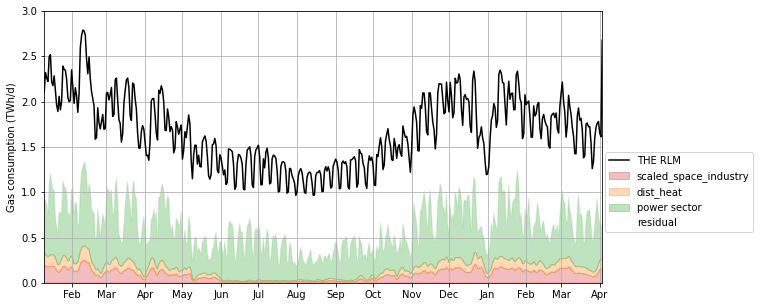

In [10]:
plt.figure(figsize=(10,5))

the_rlm = df['the_combined_rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - df['gas_to_electricity']
industry = df["scaled_space_industry"]

bottom=0
for sector, c, label in [(industry,"tab:red","scaled_space_industry"), (df["scaled_district_heat"], "tab:orange", "dist_heat"), (df['gas_to_electricity'],  "tab:green", "power sector"), (power_res,  "w", "residual")]:
    plt.fill_between(df.index, bottom, sector+bottom, color="{}".format(c), alpha=0.3, label=label)
    bottom += sector 


plt.xlim(dft.index[[0, -1]])
plt.ylim(0, 3)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.28, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

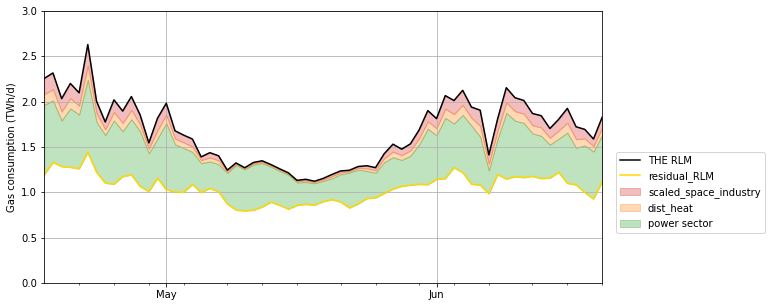

In [11]:
plt.figure(figsize=(10,5))

the_rlm = dft['the_combined_rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - dft['gas_to_electricity']
industry = dft["scaled_space_industry"]

upper=the_rlm
for sector, c, label in [(industry,"tab:red","scaled_space_industry"), (dft["scaled_district_heat"], "tab:orange", "dist_heat"), (dft['gas_to_electricity'],  "tab:green", "power sector")]:
    plt.fill_between(dft.index, upper-sector, upper , color="{}".format(c), alpha=0.3, label=label)
    upper = upper-sector 
upper.plot(color="gold", label="residual_RLM")

plt.xlim(dft.index[[0, -1]])
plt.ylim(0, 3)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b')) ##umdrehen stack

# Estimations: X^= a + b*X

In [12]:
df_x = df
df_x["power"]=df["electricity_from_gas"]**2
df_x["power"]=df["electricity_from_gas"]**2
df_x["solar"] = solar
df_x["temperature"] = temperature
df_x = df_x.rename(columns = {
    "aggregated(incl_small_chp)" : "slp_w2h",
    "dist_heat": "slp_w2h_dh",
    "the_combined_slp" : "slp_the",
    "the_combined_rlm" : "rlm_the",
    "bdew [TWh]" : "bdew",
    "gas_price [$/lhs]" : "prices"
})

In [13]:
df_x["the_sum"] = df_x["rlm_the"] + df_x["slp_the"]

In [14]:
df_x_no_holiday = df_x[(df_x.holiday==0) & (df_x.christmas_period==0) & (df_x.bridgeday==0)]

## Fit model to 2021 and predict for 2022

In [15]:
df_x_no_holiday_2022 = df_x_no_holiday.loc[df_x_no_holiday.index.year == 2022]

In [16]:
df_x_no_holiday_2021 = df_x_no_holiday.loc[df_x_no_holiday.index.year == 2021]

In [17]:
df_x_no_holiday = df_x_no_holiday.drop(columns="index")

In [18]:
df_x_no_holiday.columns

Index(['scaled_space_private', 'scaled_space_tertiary', 'scaled_decentral_chp',
       'scaled_space_industry', 'scaled_district_heat', 'slp_w2h', 'slp_the',
       'rlm_the', 'bdew', 'gas_to_electricity', 'electricity_from_gas',
       'gas_price [€/MWh]', 'time', 'year', 'month', 'weekday', 'weekday_num',
       'monday', 'friday', 'weekend', 'christmas_period', 'holiday',
       'bridgeday', 'power', 'solar', 'temperature', 'the_sum'],
      dtype='object')

## THE_RLM

In [19]:
df_x_no_holiday

,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,scaled_district_heat,slp_w2h,slp_the,rlm_the,bdew,gas_to_electricity,...,monday,friday,weekend,christmas_period,holiday,bridgeday,power,solar,temperature,the_sum
2016-10-01,NaN,NaN,NaN,NaN,NaN,NaN,0.396332,1.262703,NaN,NaN,...,0,0,1,0,0,0,NaN,NaN,NaN,1.659034
2016-10-02,NaN,NaN,NaN,NaN,NaN,NaN,0.511865,1.229047,NaN,NaN,...,0,0,1,0,0,0,NaN,NaN,NaN,1.740913
2016-10-04,NaN,NaN,NaN,NaN,NaN,NaN,0.709381,1.546009,NaN,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,2.255391
2016-10-05,NaN,NaN,NaN,NaN,NaN,NaN,0.882730,1.629043,NaN,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,2.511773
2016-10-06,NaN,NaN,NaN,NaN,NaN,NaN,0.951725,1.726405,NaN,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,2.678130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28,0.655883,0.241386,0.036947,0.061578,0.048383,1.044177,0.917907,1.437979,NaN,0.436365,...,0,0,0,0,0,0,0.018635,0.253821,NaN,2.355886
2022-04-29,NaN,NaN,NaN,NaN,NaN,NaN,0.875771,1.364176,NaN,0.453907,...,0,1,0,0,0,0,0.020164,0.230021,NaN,2.239947
2022-04-30,NaN,NaN,NaN,NaN,NaN,NaN,0.875211,1.139229,NaN,0.292613,...,0,0,1,0,0,0,0.008380,0.179968,NaN,2.014440
2022-05-02,NaN,NaN,NaN,NaN,NaN,NaN,0.824349,0.000000,NaN,NaN,...,1,0,0,0,0,0,NaN,0.222371,NaN,0.824349


In [21]:
high_gas_date = "2021-09-01"

In [22]:
#2021
model_the_21 = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas  + C(weekday)', 
                    data=df_x_no_holiday_2021)
results_the_21 = model_the_21.fit() 

#2020/09-2021/08 (before high gas prices)
model_the_20_09 = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas  + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_20_09 = model_the_20_09.fit() 

#2020/04-2021/08 (before high gas prices, after lockdown)
model_the_20_04 = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas  + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-04-01')])
results_the_20_04 = model_the_20_04.fit() 

#2016
model_the_16 = smf.ols('rlm_the ~ 1 + slp_the + electricity_from_gas  + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)])
results_the_16 = model_the_16.fit() 

#2016 controlling for months
model_the_16_m = smf.ols('rlm_the ~ 1 + slp_the + electricity_from_gas  + C(month)+ C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)])
results_the_16_m = model_the_16_m.fit() 

high_gas_date = "2021-09-01"
result_list = [
    (results_the_21,"fit_for_21", '2021-01-01', high_gas_date),
 (results_the_20_09,"fit_for_20/09_until_high_price", '2020-09-01', high_gas_date),
 (results_the_20_04,"fit_for_20/04_until_high_price", '2020-04-01', high_gas_date),
 (results_the_16,"fit_for_16_until_covid", '2016-10-01', high_gas_date),#"2020-02-01"),
 (results_the_16_m,"fit_for_16_until_covid_monthly", '2016-10-01',high_gas_date)#"2020-02-01")
]

In [23]:
combined

NameError: name 'combined' is not defined

fit_for_21    1.630565
reported      1.637916
dtype: float64
fit_for_20/09_until_high_price    1.666061
reported                          1.666061
dtype: float64
fit_for_20/04_until_high_price    1.57158
reported                          1.57158
dtype: float64
fit_for_16_until_covid    1.618154
reported                  1.611045
dtype: float64
fit_for_16_until_covid_monthly    1.618154
reported                          1.611045
dtype: float64


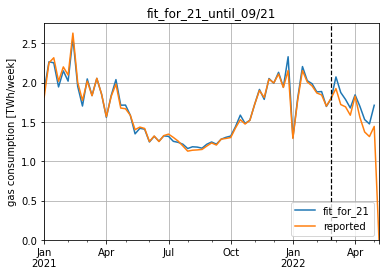

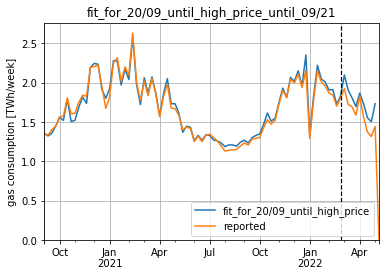

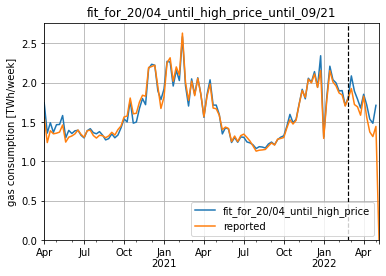

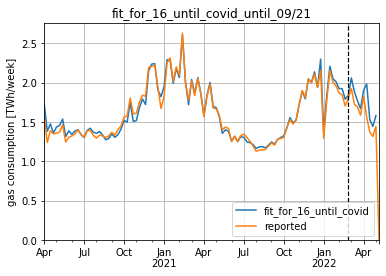

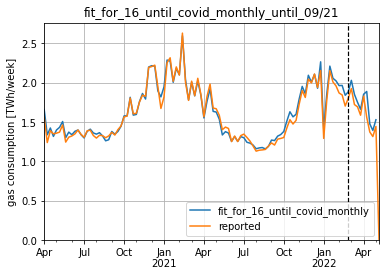

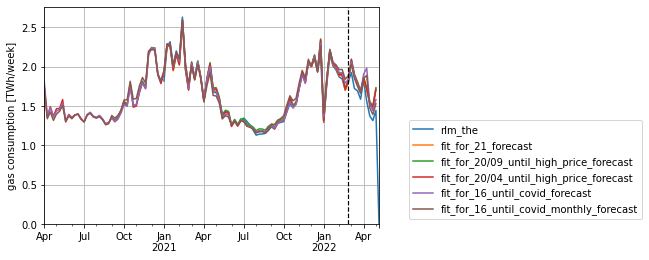

In [24]:
combined_all = df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["rlm_the"]
key_list = ["reported"]
delta_rlm = pd.DataFrame()


for df, name, start_fit, end_fit in result_list:
    
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_fit])
    
    df_pred.name = f"{name}_forecast"

    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_fit]["rlm_the"]
    ], axis=1, keys=[name, "reported"])
    print(combined.loc[(combined.index <=end_fit) & (combined.index >=start_fit)].mean())
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    delta_rlm = pd.concat([delta_rlm, ts], axis=1)
    


    ax =combined.loc["2020-04-01":].resample("1w").mean().plot(ylim=0, title = name+ "_until_09/21")
    ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
    plt.grid()
    ax.set_ylabel("gas consumption [TWh/week]")
    ax.legend(loc='upper right', bbox_to_anchor=(1, 0.2))
    
    key_list.append(name)
    
    combined_all = pd.concat([
        combined_all, df_pred
    ], axis=1, names=key_list)
    
ax = combined_all.resample("1w").mean().loc["2020-04-01":].plot(ylim=0)
ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid()
ax.set_ylabel("gas consumption [TWh/week]")
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.5))
plt.show()

##dashed fititin line 

In [27]:
delta_rlm.index = combined_all.index
delta_rlm = delta_rlm.dropna()

ValueError: Length mismatch: Expected axis has 443 elements, new values have 1876 elements

In [28]:
delta_rlm["2022-02-24":].sum(0)

fit_for_21                       -7.142544
fit_for_20/09_until_high_price   -8.673651
fit_for_20/04_until_high_price   -7.708369
fit_for_16_until_covid           -9.084285
fit_for_16_until_covid_monthly   -6.769393
dtype: float64

In [29]:
delta_rlm["2022-02-24":].index

DatetimeIndex(['2022-02-24', '2022-02-25', '2022-02-26', '2022-02-27',
               '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03',
               '2022-03-04', '2022-03-05', '2022-03-06', '2022-03-07',
               '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11',
               '2022-03-12', '2022-03-13', '2022-03-14', '2022-03-15',
               '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-19',
               '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23',
               '2022-03-24', '2022-03-25', '2022-03-26', '2022-03-27',
               '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31',
               '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04',
               '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08',
               '2022-04-09', '2022-04-10', '2022-04-11', '2022-04-12',
               '2022-04-13', '2022-04-14', '2022-04-16', '2022-04-17',
               '2022-04-19', '2022-04-20', '2022-04-21', '2022-04-22',
      

since war [TWh]:
fit_for_21                       -7.142544
fit_for_20/09_until_high_price   -8.673651
fit_for_20/04_until_high_price   -7.708369
fit_for_16_until_covid           -9.084285
fit_for_16_until_covid_monthly   -6.769393
dtype: float64
weekly:
fit_for_21                       -0.806416
fit_for_20/09_until_high_price   -0.979283
fit_for_20/04_until_high_price   -0.870300
fit_for_16_until_covid           -1.025645
fit_for_16_until_covid_monthly   -0.764286
dtype: float64


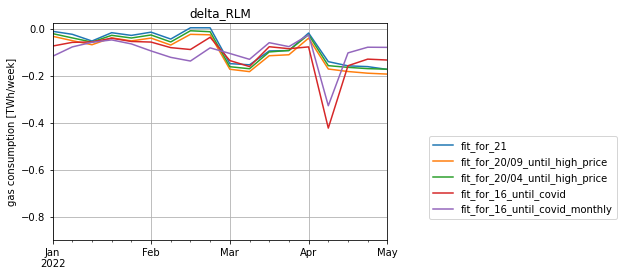

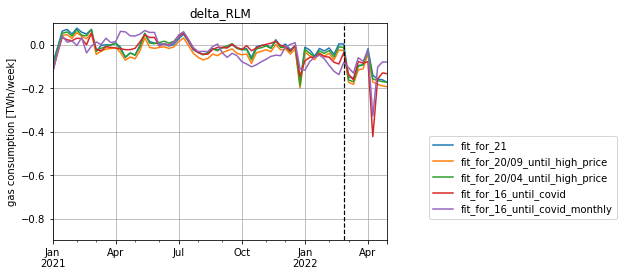

In [30]:
Q1_rlm = delta_rlm["2022-02-24":].sum(0)
weekly_rlm = Q1_rlm / len(delta_rlm["2022-02-24":].index) * 7
print("since war [TWh]:"+ "\n"+ str(Q1_rlm) + "\n" + "weekly:" + "\n"+ str(weekly_rlm))

resampled = delta_rlm.resample("1w").mean()
resampled.loc[resampled.index.year>=2022].plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="delta_RLM").set_ylabel("gas consumption [TWh/week]")
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))


resampled.plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="delta_RLM").set_ylabel("gas consumption [TWh/week]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))


plt.show()

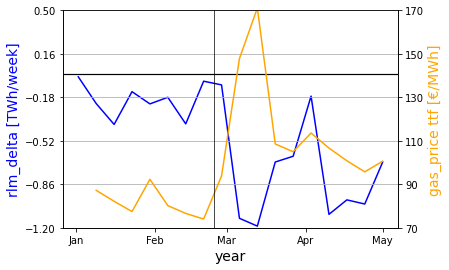

In [31]:
fig,ax = plt.subplots()

ax.plot(delta_rlm.loc[delta_rlm.index.year==2022, "fit_for_20/04_until_high_price"].resample("w").sum(), color="blue")
ax.set_ylim(-1.2, 0.5)
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("rlm_delta [TWh/week]",  color="blue", fontsize=14)
ax.set_yticks(np.arange(-1.2, 0.6, 0.34))
plt.axhline(y=0, color='k', lw=1.2)

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["gas_price [€/MWh]"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="orange")
ax2.set_ylabel("gas_price ttf [€/MWh]", color="orange", fontsize=14)
ax2.set_ylim(70, 170)
ax2.set_yticks(np.arange(70, 180, 20))
plt.axvline(x="2022-02-24", color='k', lw=0.7)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

In [ ]:
fig,ax = plt.subplots()

ax.plot(delta_rlm[delta_rlm.index.year==2022].resample("w").sum(), color="blue")
ax.set_ylim(-1.2, 0.5)
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("rlm_delta [TWh/week]",  color="blue", fontsize=14)
ax.set_yticks(np.arange(-1.2, 0.6, 0.2))
plt.axhline(y=0, color='k', lw=1.2)

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["gas_price [€/MWh]"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="orange")
ax2.set_ylabel("gas_price ttf [€/MWh]", color="orange", fontsize=14)
ax2.set_ylim(0, 170)
ax2.set_yticks(np.arange(0, 180, 20))
plt.axvline(x="2022-02-24", color='k', lw=0.7)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

In [ ]:
model_the = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas  +solar + C(weekday)', 
                            data=df_x_no_holiday_2021)
results_the = model_the.fit() 
results_the.summary()

In [ ]:
model_the = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas  + C(weekday)', 
                            data=df_x_no_holiday_2021)
results_the = model_the.fit() 
results_the.summary()
#results_the.rsquared

#model_the_slp = smf.ols('slp_the ~ 1 + slp_w2h + C(weekday)', 
#                            data=df_x_no_holiday_2021)
#results_the_slp = model_the_slp.fit() 
#results_the_slp.summary()
#results_the.rsquared

## Vizualize and analyze predictions

In [ ]:
the_rlm_prediction = results_the.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_rlm_prediction.name = "the_forecast"

the_slp_prediction = results_the_slp.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction.name = "the_slp_forecast"

the_combined = pd.concat([
    the_rlm_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["rlm_the"]
], axis=1, keys=["predicted", "reported"])
the_slp_combined = pd.concat([
    the_slp_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp_the"]
], axis=1, keys=["predicted", "reported"])

ax =the_combined.resample("1w").mean().plot(ylim=0, title="THE_rlm")
ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid()
ax.set_ylabel("gas consumption [TWh/day]")

the_slp_combined.resample("1w").mean().plot(ylim=0,  title="THE_slp").set_ylabel("gas consumption [TWh/day]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 

plt.show()


In [ ]:
delta_the_rlm = the_combined.iloc[:,1]-the_combined.iloc[:,0]
delta_the_slp = the_slp_combined.iloc[:,1]-the_slp_combined.iloc[:,0]

In [ ]:
def plot_differences(date):
    percent_rlm = round(delta_the_rlm[date:].sum() / 
                    the_combined.loc[date:, "predicted"].sum()*100)
    percent_slp = round(delta_the_slp[date:].sum() / 
                    the_combined.loc[date:, "predicted"].sum()*100)
    #plt.axhline(y=0, color='k', linestyle='--', lw=1.2)


    delta_the_rlm[date:].resample("w").sum().plot(title="reported - predicted delta since {}".format(date))
    plt.ylabel("TWh/week")
    plt.axhline(y=0, color='k', lw=1)



    
    #pd.concat([
    #    delta_the_rlm.cumsum(), delta_the_slp.cumsum()
    #], axis=1, keys=["delta rlm", "delta slp"]).plot(
    #    title="cumulated prediction delta since {} ".format(date))
    #plt.axhline(y=0, color='k', lw=1.2)
    plt.grid() 

    plt.show()

In [ ]:
plot_differences("2022-02-24")

In [ ]:
Q1_rlm = delta_the_rlm["2022-02-24":].sum()
weekly_rlm = Q1_rlm / len(delta_the_rlm["2022-02-24":].index) * 7

In [ ]:
weekly_rlm

In [ ]:
fig,ax = plt.subplots()

ax.plot(delta_the_rlm[delta_the_rlm.index.year==2022].resample("w").sum(), color="blue")
ax.set_ylim(-1.2, 0.5)
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("rlm_delta [TWh/week]",  color="blue", fontsize=14)
ax.set_yticks(np.arange(-1.2, 0.6, 0.2))
plt.axhline(y=0, color='k', lw=1.2)

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["gas_price [€/MWh]"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="orange")
ax2.set_ylabel("gas_price ttf [€/MWh]", color="orange", fontsize=14)
ax2.set_ylim(0, 170)
ax2.set_yticks(np.arange(0, 180, 20))
plt.axvline(x="2022-02-24", color='k', lw=0.7)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()